# **WORK IN PROGRESS**

In [ ]:
# Importing necessary libraries
import pandas as pd
import csv
from google.colab import files
import re
import nltk
nltk.download('stopwords')
nltk.download('all')
from nltk.corpus import stopwords

In [ ]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
# gensim changed to gensim_models
import pyLDAvis.gensim_models  # Important
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# list of the names of the json files
file_names = []
for i in range(14):
  if i<9:
    name = f"Jan0{i+1}.csv"
  elif i>=9:
    name = f"Jan{i+1}.csv"
  file_names.append(name)
print(file_names)

In [ ]:
all_files = []
for i in file_names:
  data = pd.read_csv(i)
  all_files.append(data)
print(all_files)

In [7]:
df_data = pd.concat(all_files)

In [ ]:
print(df_data)

In [9]:
df_data = df_data.rename({'Processed_Text': 'Text'}, axis='columns')

In [ ]:
print(df_data["Text"])

In [ ]:
# Removing all '\n', '\r', '\t' elements
# Using strip() and replace() to remove whitespaces
for i in range(len(df_data)):
  # Removing ' \\n ' 
  df_data['Text'].values[i] = re.sub(r"\\n", " ", df_data['Text'].values[i])
  # Removing ' \\r ' 
  df_data['Text'].values[i] = re.sub(r"\\r", " ", df_data['Text'].values[i])
    # Removing ' \\u ' 
  df_data['Text'].values[i] = re.sub(r"\\u ", " ", df_data['Text'].values[i])
  # Removing all '\'
  df_data['Text'].values[i] = re.sub(r"\W", " ", df_data['Text'].values[i])
  # REmoving all '\\t'
  df_data['Text'].values[i] = re.sub(r"\\t", " ", df_data['Text'].values[i])
  df_data['Text'].values[i] = " ".join(df_data['Text'].values[i].split())
  # Removing first element 'text'
  df_data['Text'].values[i] = df_data['Text'].values[i].split(' ', 1)[1]
  # Removing any URLs present in the dataframe
  df_data['Text'].values[i] = re.sub(r'^https?:\/\/.*[\r\n]*', '', df_data['Text'].values[i], flags=re.MULTILINE)
df_data['Text']

In [11]:
# Function to perform Tokenizing 
def tokenizing(Text):
  split = re.split('\W+', Text)
  return split

In [12]:
# Tokenizing after changing all elements to lower-case 
df_data['Text']=df_data['Text'].apply(lambda x: tokenizing(x.lower()))

In [13]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))
for m in range(len(df_data)):
 df_data['Text'].values[m] = listToString(df_data['Text'].values[m])


In [14]:
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS |= {"the", "jul", "pm", "https", "www", "printable", "version", "thehindu", "com", "news", "ece", 
               "s", "t", "d", "m", "article", "b", "rb","cwe", "click", "subscribe", "photo", "credit", "said", "topvpn",
               "right", "caused", "said", "people", "city", "official", "said", "year", "state", "held"}
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()
for m in range(len(df_data)):
  text =df_data['Text'].values[m]
    #"nlp" Object is used to create documents with linguistic annotations.
  my_doc = nlp(text)

  # Create list of word tokens
  token_list = []
  for token in my_doc:
    token_list.append(token.text)

  # Create list of word tokens after removing stopwords
  filtered_sentence =[] 

  for word in token_list:
   lexeme = nlp.vocab[word]
   if lexeme.is_stop == False:
        filtered_sentence.append(word) 
  r = filtered_sentence
  df_data['Text'].values[m] = r

In [15]:
text_list = []
for j in range(len(df_data)):
  for i in df_data['Text'].values[j]:
    text_list.append(i)
len(text_list)

838811

In [ ]:
text_list

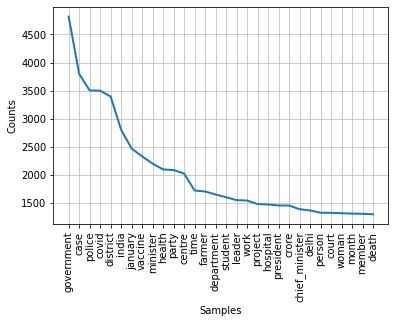

In [16]:
import nltk
from nltk.corpus import webtext
from nltk.probability import FreqDist
data_analysis = nltk.FreqDist(text_list)
  
  # Let's take the specific words only if their frequency is greater than 3.
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 3])
  
  #for key in sorted(filter_words):
  #    print("%s: %s" % (key, filter_words[key]))
  
data_analysis = nltk.FreqDist(filter_words)
data_analysis.plot(30, cumulative=False)

In [ ]:
# Observing one element of the dataframe
print(df_data["Text"])

# **TRAIN TEST SPLIT**

In [17]:
import sklearn
train, test = sklearn.model_selection.train_test_split(df_data, test_size=0.10, random_state=42 )

In [18]:
print("Train Feature set:\t"+str(len(train)))
print("Train Feature set:\t"+str(len(test)))

Train Feature set:	4263
Train Feature set:	474


**EMBEDDINGS**

> **BAG OF WORDS**

In [19]:
data =df_data["Text"].tolist()

In [ ]:
print(data[0])

In [20]:
list_clean = []
# Removing all words which have less than 4 letters 
for i in data:
  clean = []
  for x in i:
    if len(x) >2:
      clean.append(x)
  list_clean.append(clean)
data = list_clean

In [ ]:
data

In [ ]:
print(train["Text"])

In [ ]:
 from gensim import corpora
# Creating a Dictionary as input to the LDA model 
dictionary = corpora.Dictionary(train["Text"])

# Creating corpus
corp = train["Text"]

corpus = [dictionary.doc2bow(text) for text in corp]
print(corpus)


# **HYPERPARAMETER TESTING**

**FINDING THE OPTIMAL NUMBER OF TOPICS**

In [22]:
# Defining  a function to compute the coherence value based on the different values of TOPICS
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=10,
                                           chunksize=a,
                                           iterations = b,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# calling the function 'compute_coherence_values' for different values of k: number of topics
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 11
max_topics = 40
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
chuncksize =[100]
#alpha.append('symmetric')
#alpha.append('asymmetric')
# Beta parameter
iterations = [100]
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'chunksize': [],
                 'iterations': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=550)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in chuncksize:
                # iterare through beta values
                for b in iterations:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, k=k, a=a, b=b)
                                                
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['chunksize'].append(a)
                    model_results['iterations'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    
    pbar.close()

In [ ]:
# Creating a dataframe to plot coherence Vs K
import pandas as pd
df_hyp = pd.DataFrame(model_results)

In [ ]:
print(df_hyp)

   Validation_Set  Topics  chunksize  iterations  Coherence
0     100% Corpus      11        100         100   0.485605
1     100% Corpus      13        100         100   0.465797
2     100% Corpus      15        100         100   0.515993
3     100% Corpus      17        100         100   0.497494
4     100% Corpus      19        100         100   0.511972
5     100% Corpus      21        100         100   0.508482
6     100% Corpus      23        100         100   0.514933
7     100% Corpus      25        100         100   0.555076
8     100% Corpus      27        100         100   0.537723
9     100% Corpus      29        100         100   0.519049
10    100% Corpus      31        100         100   0.531317
11    100% Corpus      33        100         100   0.508941
12    100% Corpus      35        100         100   0.489803
13    100% Corpus      37        100         100   0.494780
14    100% Corpus      39        100         100   0.498967


**BEST COHERENCE SCORE FOR K=25**

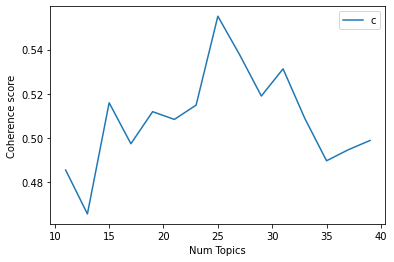

In [ ]:
# Show graph
plt.plot(df_hyp["Topics"],df_hyp["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Defining  a function to compute the coherence value based on the different values of ETA
def compute_coherence_values(corpus, dictionary, b):#, b
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=25, 
                                           random_state=10,
                                           chunksize=100,
                                           iterations = 100,
                                           alpha = 'symmetric',
                                           eta = b,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Alpha parameter
#alpha = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#alpha.append('symmetric')
#alpha.append('asymmetric')
# Beta parameter
eta = [0.04, 0.1, 0.16, 0.22, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.5, 1.7, 1.9, 2]
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['100% Corpus']
model_results3 = {'Validation_Set': [],
                 'Topics': [],
                 'eta': [],
                 #'alpha': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=16)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
            # iterate through alpha values
        for b in eta:
                # iterare through beta values
                #for b in iterations:
                    # get the coherence score for the given parameters
             cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,b=b) # ,b=b
                                                
            # Save the model results
             model_results3['Validation_Set'].append(corpus_title[i])
             model_results3['Topics'].append(k)
             model_results3['eta'].append(b)
             #model_results['iterations'].append(b)
             model_results3['Coherence'].append(cv)
                    
             pbar.update(1)
    
    pbar.close()

In [ ]:
df_hyp3 = pd.DataFrame(model_results3)

In [ ]:
print(df_hyp3)

   Validation_Set  Topics   eta  Coherence
0     100% Corpus      39  0.04   0.544250
1     100% Corpus      39  0.10   0.593064
2     100% Corpus      39  0.16   0.570870
3     100% Corpus      39  0.22   0.616531
4     100% Corpus      39  0.50   0.722302
5     100% Corpus      39  0.60   0.745579
6     100% Corpus      39  0.70   0.673337
7     100% Corpus      39  0.80   0.673444
8     100% Corpus      39  0.90   0.667301
9     100% Corpus      39  1.00   0.644730
10    100% Corpus      39  1.20   0.789274
11    100% Corpus      39  1.50   0.806035
12    100% Corpus      39  1.70   0.832153
13    100% Corpus      39  1.90   0.821279
14    100% Corpus      39  2.00   0.797613


**BEST COHERENCE VALUE FOR ETA=1.70**

In [ ]:
# FINDING BEST VALUE OF ALPHA 
model_results1

{'Coherence': [0.5474975174680901,
  0.5465053357854427,
  0.5161641177138201,
  0.5217461283035881,
  0.5179340715296894,
  0.5105772713684952,
  0.49548984280940117,
  0.49615924715742254,
  0.49399122356792646,
  0.49503454437501304,
  0.5000073459705362,
  0.5571517074661875,
  0.5509248468291763],
 'Topics': [39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39],
 'Validation_Set': ['100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus',
  '100% Corpus'],
 'alpha': [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'symmetric', 'asymmetric'],
 'eta': []}

**BEST VALUE OF COHERENCE IS FOR ALPHA = "symmetric"**

**BUILDING THE TOPIC MODEL**

**USING BAG OF WORDS**

In [23]:
# LDA Model building 
#, alpha = 0.5, eta = 1.6, passes= 10, workers=2, chunksize = 100, iterations= 150 , alpha=0.5, eta=1.6 , alpha = 8
lda_model = gensim.models.LdaMulticore(corpus, num_topics=25 , id2word=dictionary, random_state=10, chunksize = 100, passes= 20, workers=4, iterations=100, alpha='symmetric')

In [24]:
# Viewing the topics formed
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"film" + 0.008*"new" + 0.006*"like" + 0.005*"world" + 0.005*"help" + 0.005*"actor" + 0.005*"book" + 0.004*"word" + 0.004*"work" + 0.004*"life"
Topic: 1 
Words: 0.018*"train" + 0.015*"railway" + 0.010*"coimbatore" + 0.008*"service" + 0.006*"special" + 0.006*"camp" + 0.006*"central" + 0.006*"reach" + 0.006*"scheme" + 0.005*"card"
Topic: 2 
Words: 0.012*"yediyurappa" + 0.009*"bengaluru" + 0.008*"student" + 0.007*"day" + 0.007*"tribute" + 0.007*"express_solidarity" + 0.006*"course" + 0.006*"rural_area" + 0.006*"energy" + 0.006*"passed_away"
Topic: 3 
Words: 0.013*"india" + 0.010*"government" + 0.005*"country" + 0.005*"indian" + 0.005*"development" + 0.005*"action" + 0.005*"ministry" + 0.004*"national" + 0.004*"new" + 0.004*"pakistan"
Topic: 4 
Words: 0.008*"crisis" + 0.007*"pok_legislative" + 0.007*"elections_marred" + 0.006*"code" + 0.005*"building" + 0.005*"led" + 0.005*"nuclear" + 0.005*"china" + 0.005*"set" + 0.004*"protest"
Topic: 5 
Words: 0.018*"government" + 

**MODEL EVALUATION**

In [25]:
# Compute Perplexity

print("With Bag Of Words:\n")
print('\nPerplexity with BoW: ', lda_model.log_perplexity(corpus), )  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score using BOW: ', coherence_lda)

With Bag Of Words:


Perplexity with BoW:  -8.639665500277907

Coherence Score using BOW:  0.5770613544918839


In [26]:
lda_model.save('Model2')

**MODEL VISUALIZATION**

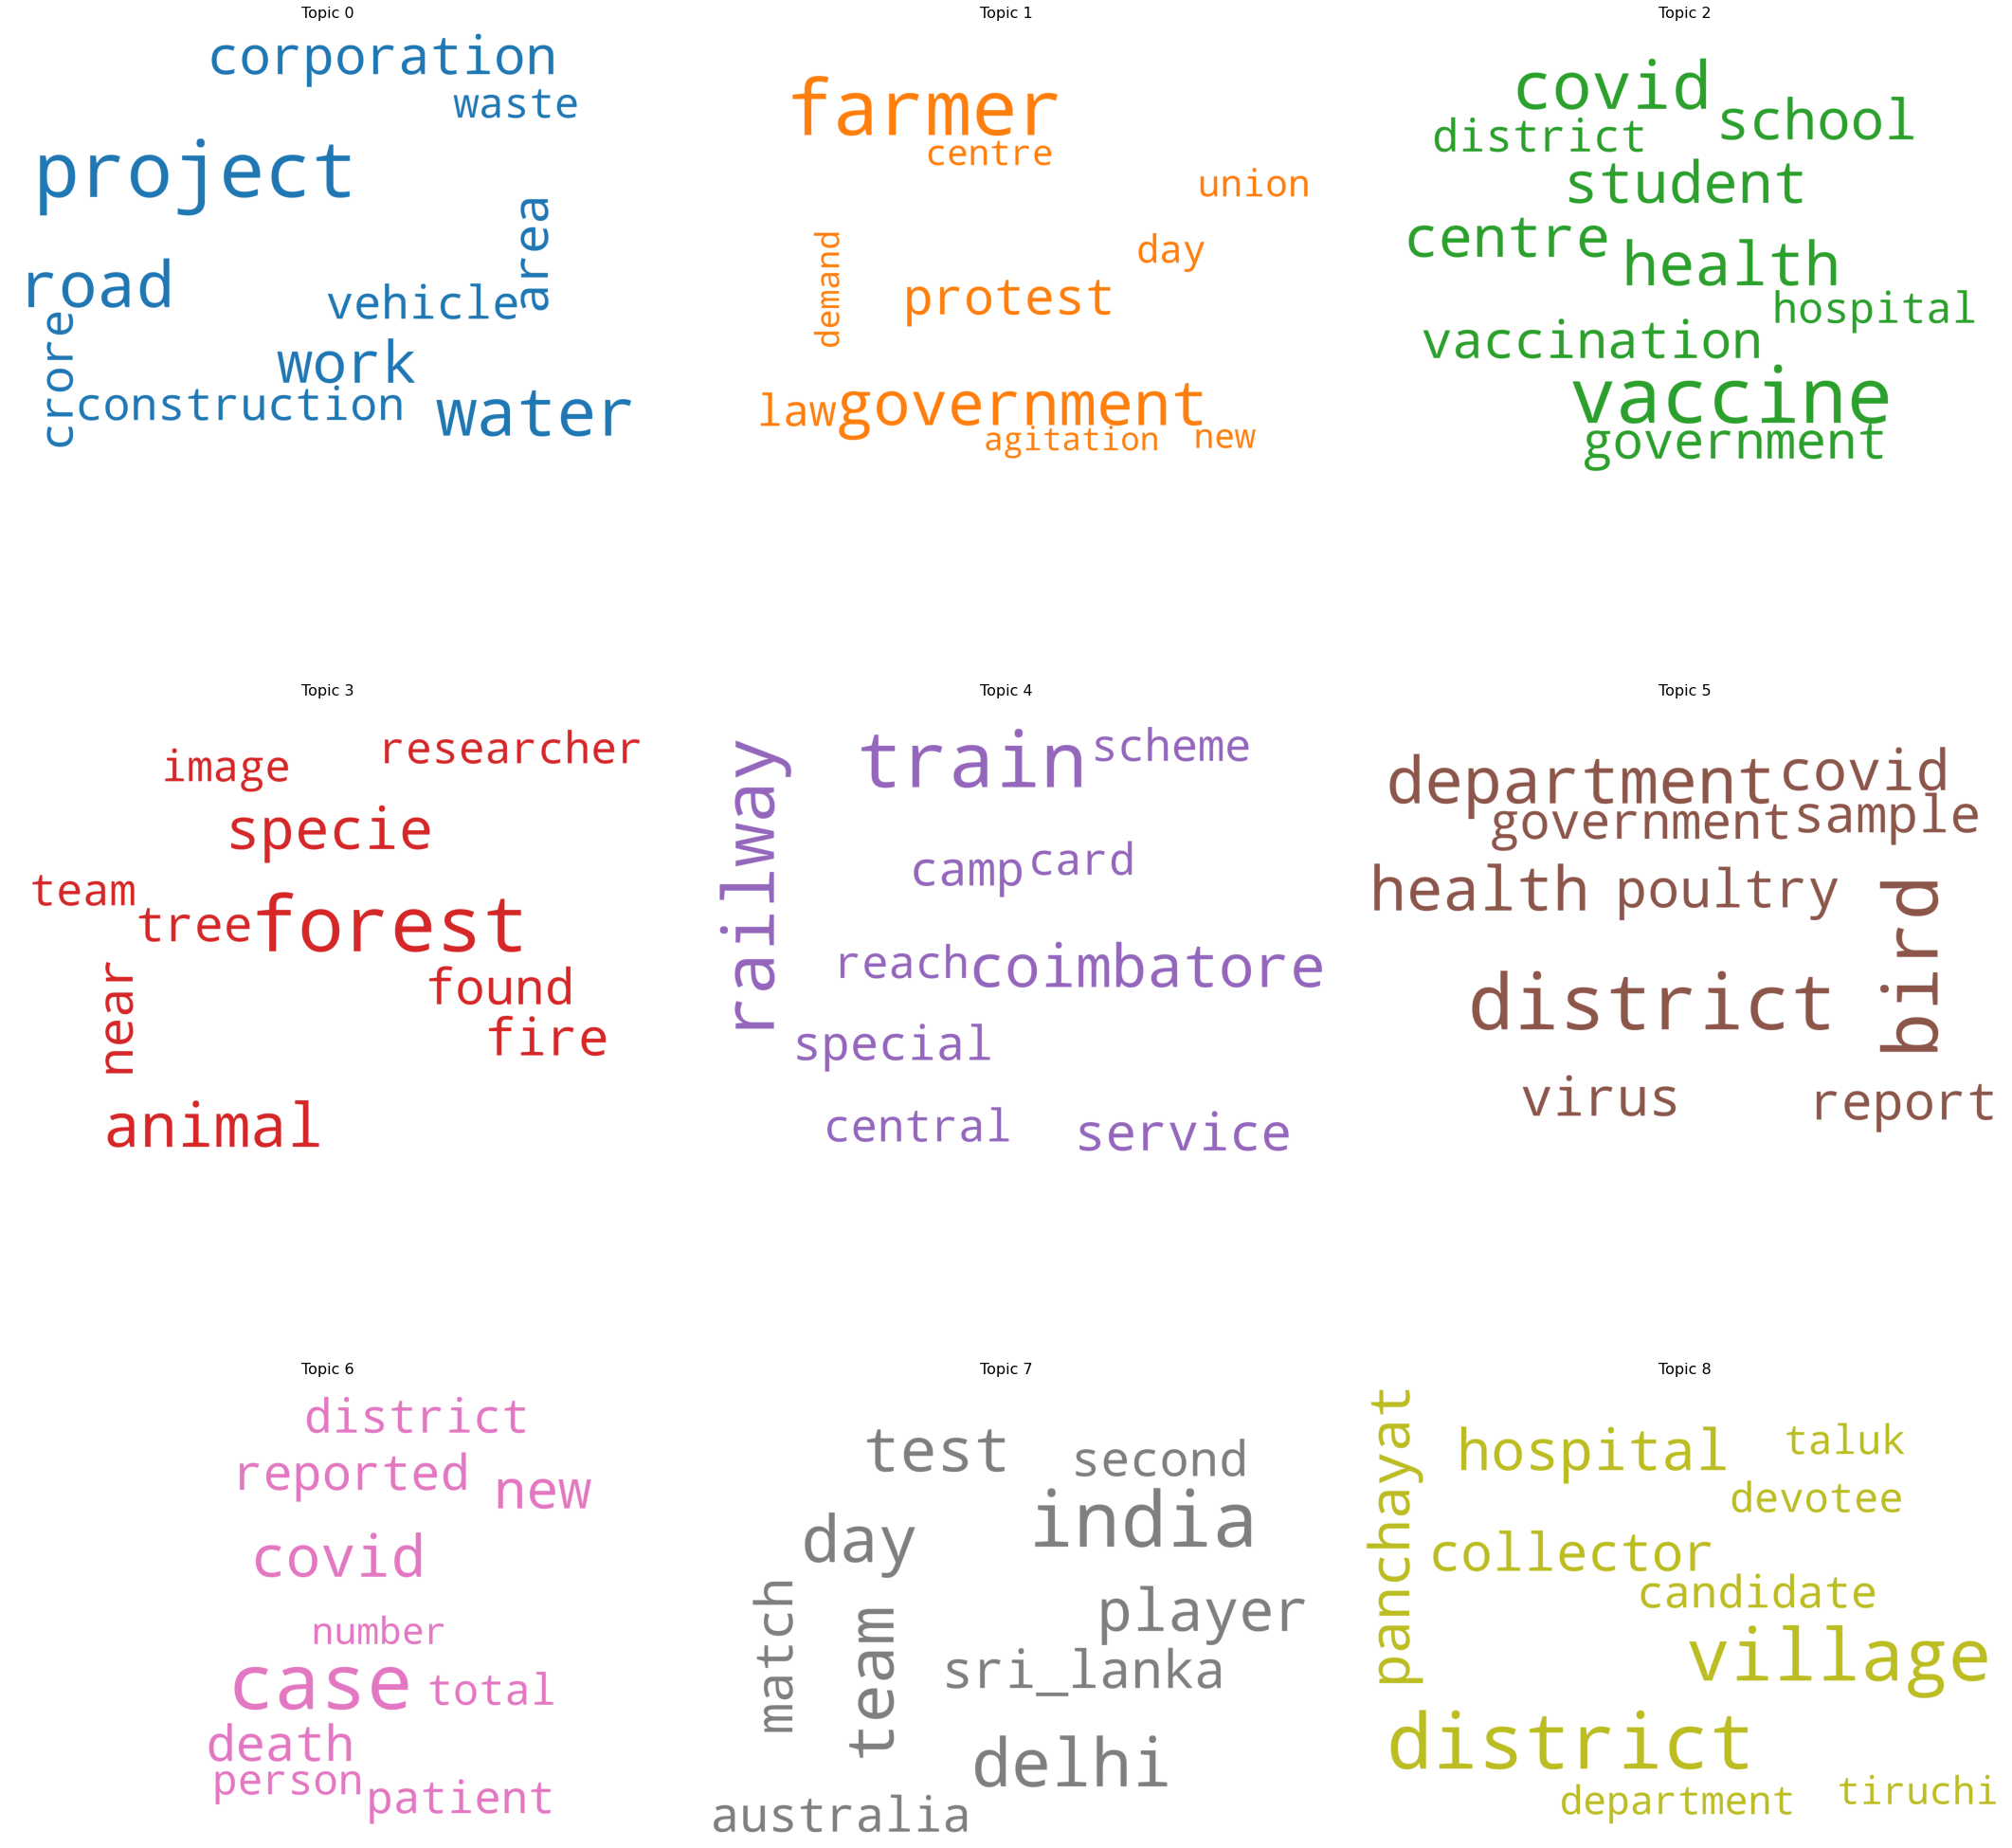

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Assigning different colors to each word cloud
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

# Drawing the word cloud 
Word_cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=40,
                  colormap='tab10',
                  contour_color='steelblue',
                  color_func=lambda *args, **kwargs: cols[i])

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    Word_cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(Word_cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=30)
plt.axis('off')
plt.margins(x=20, y=20)
plt.tight_layout()
plt.show()

In [ ]:
print(test)

In [29]:
test_list = test["Text"].to_list()

In [ ]:
test_list

In [31]:
topic_dist = []
for i in range(len(test_list[0:10])):
  text = test_list[i]
  print("The topic dominant in the doccument number {}: ".format(i+1),lda_model[dictionary.doc2bow(text)])
  topic_dist.append(lda_model[dictionary.doc2bow(text)])

The topic dominant in the doccument number 1:  [(3, 0.027848195), (6, 0.033973176), (9, 0.70241445), (11, 0.1852783), (14, 0.02447467)]
The topic dominant in the doccument number 2:  [(2, 0.038082346), (3, 0.035486743), (5, 0.13898346), (7, 0.15583844), (11, 0.39339933), (12, 0.012598767), (16, 0.02081571), (18, 0.012901075), (20, 0.09297034), (22, 0.093660645)]
The topic dominant in the doccument number 3:  [(0, 0.10004583), (6, 0.10839539), (13, 0.08517837), (14, 0.2515683), (15, 0.020378524), (18, 0.041460957), (19, 0.06836572), (20, 0.04902305), (23, 0.08650187), (24, 0.18470246)]
The topic dominant in the doccument number 4:  [(3, 0.13507867), (4, 0.013221003), (6, 0.01057926), (8, 0.18807098), (11, 0.089738995), (13, 0.3980366), (14, 0.015295594), (19, 0.042232923), (22, 0.07727741)]
The topic dominant in the doccument number 5:  [(0, 0.051743936), (3, 0.018218644), (5, 0.04083625), (9, 0.028805336), (10, 0.39456007), (11, 0.029972536), (12, 0.01274609), (14, 0.09278378), (15, 0.

In [33]:
# Creating the dataframe of the test dataset 
df_test = pd.DataFrame(zip(test["File_Name"], test_list, topic_dist), columns = ["File_Name", "Text", "Distribution"])

In [ ]:
print(df_test[0:10])

                       File_Name  ...                                       Distribution
0   thehindu_jan_8_file_235.json  ...  [(0, 0.038113173), (1, 0.034132197), (2, 0.033...
1   thehindu_jan_1_file_388.json  ...  [(0, 0.07728041), (1, 0.07122896), (2, 0.06269...
2    thehindu_jan_5_file_74.json  ...  [(0, 0.23164204), (1, 0.094689876), (2, 0.0421...
3    thehindu_jan_6_file_24.json  ...  [(0, 0.04482384), (1, 0.05182743), (2, 0.05176...
4  thehindu_jan_12_file_198.json  ...  [(0, 0.07740685), (1, 0.0765289), (2, 0.057061...
5   thehindu_jan_1_file_245.json  ...  [(0, 0.050323192), (1, 0.067411855), (2, 0.071...
6   thehindu_jan_4_file_117.json  ...  [(0, 0.076724514), (1, 0.04859568), (2, 0.0464...
7   thehindu_jan_4_file_204.json  ...  [(0, 0.04821251), (1, 0.06768358), (2, 0.04706...
8   thehindu_jan_8_file_213.json  ...  [(0, 0.060089123), (1, 0.055146113), (2, 0.054...
9   thehindu_jan_14_file_22.json  ...  [(0, 0.08336308), (1, 0.06505992), (2, 0.07824...

[10 rows x 3 columns